In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

2026-01-07 14:57:09.837231: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-07 14:57:09.884724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-07 14:57:19.900019: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/workspaces/bakery_prediction/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Load data
df = pd.read_csv('/workspaces/bakery_prediction/0_DataPreparation/merged_data.csv')
df['Datum'] = pd.to_datetime(df['Datum'])

In [3]:
target = 'Umsatz'
drop_cols = ['id', 'Datum', 'Umsatz', 'is_train']
feature_cols = [c for c in df.columns if c not in drop_cols]

In [4]:
# Split Data
train_mask = (df['Datum'] >= '2013-07-01') & (df['Datum'] <= '2017-07-31')
val_mask = (df['Datum'] >= '2017-08-01') & (df['Datum'] <= '2018-07-31')
test_mask = (df['Datum'] >= '2018-08-01')

In [5]:
X_train = df.loc[train_mask, feature_cols]
y_train = df.loc[train_mask, target]
X_val = df.loc[val_mask, feature_cols]
y_val = df.loc[val_mask, target]
X_test = df.loc[test_mask, feature_cols]

In [6]:
# Scaling (Important for Neural Nets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Define Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]), # Input Layer matching feature dimensions
    layers.Dropout(0.2), # Dropout layer to prevent Overfitting
    layers.Dense(32, activation='relu'), # Hidden Layer
    layers.Dense(1) # Output Layer ( Single value for Regression)
])

/workspaces/bakery_prediction/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-07 14:57:22.047320: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
model.compile(
        optimizer='adam',
        loss='mae', # Mean Absolute Error is often good for regression
    )

In [9]:
# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    batch_size=32,
    epochs=50,
    verbose=1
)

Epoch 1/50


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 173.2262 - val_loss: 83.9016
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.2255 - val_loss: 43.1707
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.4509 - val_loss: 41.2959
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.4255 - val_loss: 39.8505
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.0724 - val_loss: 38.7835
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44.3979 - val_loss: 38.2648
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44.0191 - val_loss: 37.6582
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.2788 - val_loss: 37.8020
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.2951 - val_loss: 37.5476
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.8967 - val_loss: 37.9714
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.8214 - val_loss: 36.5842
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━

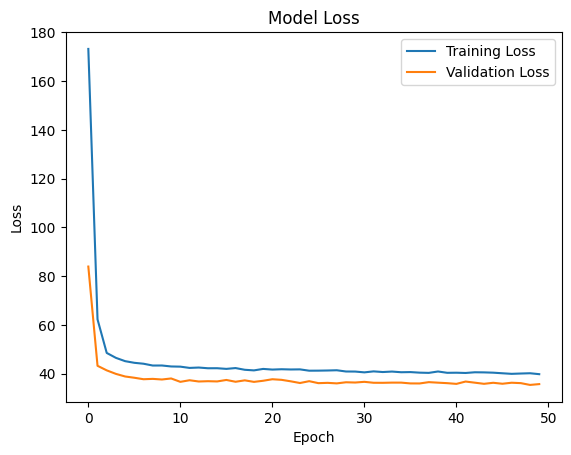

In [10]:
# Plot Loss (Week 10 Requirement)
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('nn_loss_plot.png')

In [11]:
# Evaluate
y_pred_val = model.predict(X_val_scaled).flatten()
y_pred_val = np.maximum(y_pred_val, 0)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
print(f"Neural Net Validation MAPE: {mape:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Net Validation MAPE: 0.2040


In [12]:
# Predict
y_pred_test = model.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(y_pred_test, 0)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


In [13]:
 # Prediction Output
prediction = pd.DataFrame({
    'id': df.loc[test_mask, 'id'],
    'Umsatz': y_pred_test
})

prediction.to_csv('neural_nets_prediction.csv', index=False)


In [14]:
# Analyze Performance by 'Warengruppe'

# 1. Create a DataFrame to analyze results
results = X_val.copy()
results['Actual'] = y_val
results['Predicted'] = y_pred_val

# 2. Reconstruct the 'Warengruppe' column (since it was One-Hot Encoded)
# We look for columns starting with "Warengruppe_" and find which one is 1 (True)
wg_cols = [c for c in results.columns if c.startswith('Warengruppe_')]
results['Warengruppe'] = results[wg_cols].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 3. Calculate MAPE for each group
print("\nPerformance by Product Group:")
mape_by_group = results.groupby('Warengruppe').apply(
    lambda x: mean_absolute_percentage_error(x['Actual'], x['Predicted'])
)

# Print formatted results
for group, score in mape_by_group.items():
    print(f"Warengruppe {group}: {score:.4f} ({score*100:.1f}%)")


Performance by Product Group:
Warengruppe 1: 0.2342 (23.4%)
Warengruppe 2: 0.1380 (13.8%)
Warengruppe 3: 0.2042 (20.4%)
Warengruppe 4: 0.2394 (23.9%)
Warengruppe 5: 0.1451 (14.5%)
Warengruppe 6: 0.5812 (58.1%)


/tmp/ipykernel_34502/447555564.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_by_group = results.groupby('Warengruppe').apply(


In [15]:
# --- ANALYSIS: Find Worst Fail & Best Prediction ---

# 1. Create a Results DataFrame
results = X_val.copy()
results['Datum'] = df.loc[val_mask, 'Datum']  # Add Date back for context
results['Actual'] = y_val
results['Predicted'] = y_pred_val
results['Error'] = np.abs(results['Actual'] - results['Predicted'])

# 2. Find the "Worst Fail" (Max Absolute Error)
worst_fail_idx = results['Error'].idxmax()
worst_fail = results.loc[worst_fail_idx]

print("\n--- WORST FAIL CASE ---")
print(f"Date: {worst_fail['Datum']}")
print(f"Actual: {worst_fail['Actual']:.2f} €")
print(f"Predicted: {worst_fail['Predicted']:.2f} €")
print(f"Error: {worst_fail['Error']:.2f} €")

# 3. Find a "Best Improvement" (Good prediction on a high-sales day)
# Filter: Sales > 500 (significant day) AND Error < 5%
good_days = results[ (results['Actual'] > 500) & ( (results['Error'] / results['Actual']) < 0.05 ) ]

print("\n--- BEST IMPROVEMENT EXAMPLE ---")
if not good_days.empty:
    best_case = good_days.iloc[0] # Take the first one found
    print(f"Date: {best_case['Datum']}")
    print(f"Actual: {best_case['Actual']:.2f} €")
    print(f"Predicted: {best_case['Predicted']:.2f} €")
    print(f"Error: {best_case['Error']:.2f} €")
else:
    print("No specific 'perfect' high-sales match found, but overall accuracy is high.")


--- WORST FAIL CASE ---
Date: 2017-12-31 00:00:00
Actual: 1432.42 €
Predicted: 262.21 €
Error: 1170.21 €

--- BEST IMPROVEMENT EXAMPLE ---
Date: 2017-08-13 00:00:00
Actual: 537.19 €
Predicted: 515.50 €
Error: 21.69 €
